In [152]:
import os, sys
import random

import matplotlib.pyplot as plt
import numpy as np
import joblib
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.utils.data
import torchvision.transforms as transforms
from munch import Munch
from PIL import Image
from torch.autograd import Variable
import torchvision.models as models

In [2]:
meta_data = joblib.load('../data/ddsm_meta_data.jbl')
unit_labels = joblib.load('../data/cleaned_unit_labels.jbl')

In [142]:
data_root = os.environ.get('DATA_ROOT', '../data/ddsm_raw/')
image_list_dir = os.environ.get('IMAGE_LIST_DIR', '../data/ddsm_raw_image_lists/')
config_path = os.environ.get('CONFIG_PATH', '../training/pretrained/resnet152_3class/config.yml')
epoch = int(os.environ.get('EPOCH', '5'))
class_index = int(os.environ.get('CLASS_INDEX', '2'))
split = os.environ.get('SPLIT', 'val2')

image_list_path = os.path.join(image_list_dir, '{}.txt'.format(split))
image_list_path

with open(config_path, 'r') as f:
    cfg = Munch.fromYAML(f)

if cfg.arch.num_classes == 3:
    mask_root = '../data/ddsm_masks/3class/'

In [70]:
def surgery(model, arch, num_classes):
    if arch == 'inception_v3' or arch == 'resnet152':
        model.module.fc.cpu()
        state_dict = model.state_dict()
        state_dict['module.fc.weight'] = state_dict['module.fc.weight'].view(num_classes, 2048, 1, 1)
        model.module.fc = nn.Conv2d(2048, num_classes, kernel_size=(1, 1))
        model.load_state_dict(state_dict)

        if torch.cuda.is_available():
            model.module.fc.cuda()
    else:
        raise Exception
class DDSM(torch.utils.data.Dataset):
    def __init__(self, root, image_list_path, split, patch_size, transform):
        self.root = root
        with open(image_list_path, 'r') as f:
            self.image_names = list(map(lambda line: line.split()[0], f.readlines()))
        self.patch_size = patch_size
        self.transform = transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        image = Image.open(os.path.join(self.root, image_name))
        min_dim = min(image.size)
        ratio = float(4 * self.patch_size) / min_dim
        new_size = (int(ratio * image.size[0]), int(ratio * image.size[1]))
        image = image.resize(new_size, resample=Image.BILINEAR)
        image = np.asarray(image)
        # If the images are bw, (h,w) shape, need to expand into a 3 channel image
        image = np.broadcast_to(np.expand_dims(image, 2), image.shape + (3,))
        image = self.transform(image)
        return image_name, image        

In [5]:
cd ../training/

/Users/gen/donuts/ddsm-visual-primitives/training


In [6]:
import resnet

In [135]:
model_names = sorted(name for name in models.__dict__
    if name.islower() and not name.startswith("__")
    and callable(models.__dict__[name]))

print("=> creating model '{}'".format(cfg.arch.model))
if cfg.arch.model == 'inception_v3':
    model = models.inception.inception_v3(use_avgpool=False, transform_input=True)
    model.aux_logits = False
    model.fc = nn.Linear(2048, cfg.arch.num_classes)
    features_layer = model.Mixed_7c
elif cfg.arch.model == 'resnet152':
    #model = models.resnet.resnet152()
    # Local version of resnet used so that CAM could be reconstructed
    model = resnet.resnet152()
    model.fc = nn.Linear(2048, cfg.arch.num_classes)
    features_layer = model.layer4
else:
    raise Exception

model = torch.nn.DataParallel(model)
if torch.cuda.is_available():
    model = model.cuda()
    
cudnn.benchmark = True

resume_path = cfg.training.resume.replace(cfg.training.resume[-16:-8], '{:08}'.format(epoch))
if os.path.isfile(resume_path):
    print("=> loading checkpoint '{}'".format(resume_path))
    if torch.cuda.is_available():
        checkpoint = torch.load(resume_path)
    else:
        checkpoint = torch.load(resume_path, map_location='cpu')
    start_epoch = checkpoint['epoch']
    model.load_state_dict(checkpoint['state_dict'])
    model.eval()
    print("=> loaded checkpoint '{}' (epoch {})".format(resume_path, checkpoint['epoch']))
else:
    print("=> no checkpoint found at '{}'".format(resume_path))

surgery(model, cfg.arch.model, cfg.arch.num_classes)

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
patch_size = 299 if cfg.arch.model == 'inception_v3' else 227
dataset = DDSM(data_root, image_list_path, split, patch_size, transforms.Compose([
    transforms.ToTensor(),
    normalize,
]))

=> creating model 'resnet152'
=> loading checkpoint 'pretrained/resnet152_3class/checkpoint_00000005.pth.tar'
=> loaded checkpoint 'pretrained/resnet152_3class/checkpoint_00000005.pth.tar' (epoch 5)


In [136]:
# extract features and max activations
features = []
def feature_hook(module, input, output):
    features.extend(output.data.cpu().numpy())
features_layer._forward_hooks.clear()
features_layer.register_forward_hook(feature_hook)
prob_maps = []
max_class_probs = []
for _, image in dataset:
    input_var = Variable(image.unsqueeze(0), volatile=True)
    output = model(input_var)    
    output = output.transpose(1, 3).contiguous()
    size = output.size()[:3]
    output = output.view(-1, output.size(3))
    prob = nn.Softmax()(output)
    prob = prob.view(size[0], size[1], size[2], -1)
    prob = prob.transpose(1, 3)
    prob = prob.data.cpu().numpy()
    prob_map = prob[0][class_index]
    prob_maps.append(prob_map)
    max_class_probs.append(prob_map.max())
    # For testing this notebook, only extract one report's features
    break
max_class_probs = np.array(max_class_probs)
image_indices = np.argsort(-max_class_probs)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


In [137]:
max_class_probs

array([0.97167027], dtype=float32)

In [111]:
image_indices

array([0])

In [112]:
num_units = [1, 2, 4, 8, 20]
predicted_reports = {}
for num_top_units in num_units:
    max_activations = np.array([feature_map.max(axis=(1, 2)) for feature_map in features])
    #max_activations = np.expand_dims(max_activations, 1)
    params = list(model.parameters())
    weight_softmax = params[-2].data.cpu().numpy().squeeze(3).squeeze(2)
    weighted_max_activations = max_activations * weight_softmax[class_index, :]
    #unit_indices = np.argsort(-weighted_max_activations, axis=2)
    #unit_indices = unit_indices[:, :, :num_top_units]
    unit_indices = np.argsort(-weighted_max_activations, axis=1)
    unit_indices = unit_indices[:, :num_top_units]

    # reports
    for image_index in image_indices: 
        image_name, image = dataset[image_index]
        try:
            gt_report = [g[1] for g in meta_data['meta'][image_name]]
        except:
            # this image didn't have a GT report
            continue
        indices = unit_indices[image_index]
        caption = ' '.join(['unit_{:04}'.format(unit_index + 1) for unit_index in indices])
        unit_report = []
        for uidx in ['unit_{:04}'.format(unit_index + 1) for unit_index in indices]:
            if uidx in unit_labels.keys():
                unit_report.append(unit_labels[uidx])
        try:
            tmp = predicted_reports[image_name]
        except:
            predicted_reports[image_name] = []
        
        predicted_reports[image_name].append([gt_report, unit_report])
        print('image {} gt report: {}'.format(image_name, gt_report))
        print('class {} top units: {}'.format(class_index, caption))
        print('unit report: {}'.format(unit_report))    
        print('')    

In [56]:
from PIL import Image, ImageDraw

## TODO: test these functions

def overlay_mask(image_name, im_shape):
    ''' This returns the lesion mask for a given ddsm image if it exists.
    '''
    overlay_name = ('.'.join(os.path.basename(image_name).split('.')[0:2]))+'.OVERLAY'
    overlay_path = os.path.join(ddsm_data_dir, overlay_name)
    
    chain_codes = []
    with open(overlay_path) as overlay:
        for row in overlay:
            # add overlay outline
            if 'TOTAL_OUTLINES' in row:
                num_outlines = int(row.split()[-1])
            if 'LESION_TYPE' in row:
                lesion_type = row.split(' ')[1].strip('\n')
                scan.global_label = lesion_lbl[lesion_type]
            if '#' in row:
                chain_codes.append([int(j) for j in row.split()[:-1]])
    masks = []        
    for ind, outline_code in enumerate(chain_codes):
        masks.append( chain_code(im_shape, start_loc=outline_code[:2], code=outline_code[2:]) )
    
    return masks
                
                

def chain_code(image_name, im_shape, start_loc, code):
    ''' This is for converting a DDSM overlay chain code into a binary
    mask.
    '''    
    chain_moves = [(0,-1), (1,-1), (1,0), (1,1), (0,1), (-1,1), (-1,0), (-1,-1)]

    # PIL Image uses (col, row) coordinates instead of (row, col)
    polygon = [tuple(start_loc)]
    for move_ind in code:
        move = chain_moves[move_ind]
        polygon.append(tuple(map(sum, zip(polygon[-1], move))))

    # PIL Image take size in (col, row) format
    img = Image.new('L', (im_shape[1], im_shape[0]), 0)
    ImageDraw.Draw(img).polygon(polygon, outline=1, fill=1)
    mask = np.asarray(img)

    return mask

In [57]:
unit_labels = joblib.load('../data/cleaned_resnet152_3class_unit_labels.jbl')

image name: cancer_11-A_1673_1.LEFT_CC.LJPEG.1.jpg
class 2 prob: 0.9716702699661255


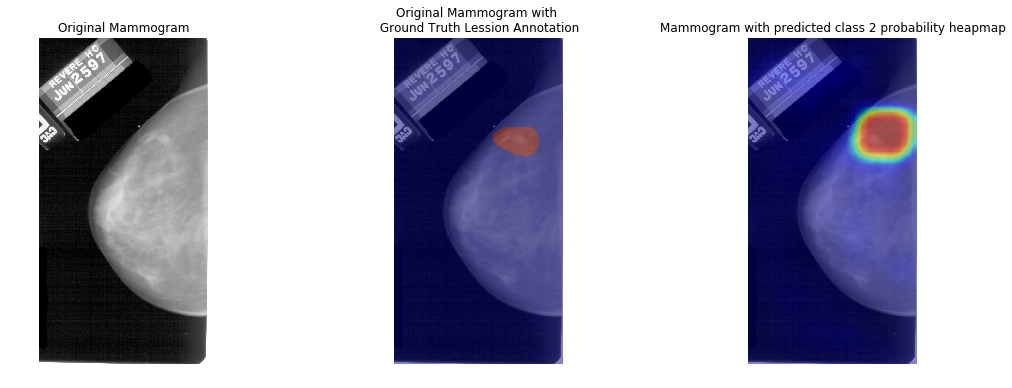

class 2 top units:
	 unit_1152 : Malignant pleomorphic calcifications
	unit_0594 : 
	unit_1001 : Calcified vessels
	unit_0588 : 
	unit_1549 : Normal Breast Tissue
	unit_1056 : 
	unit_1311 : Normal Breast Tissue
	unit_1945 : 
	unit_0257 : 
	unit_0772 : 
	unit_0402 : 
	unit_1227 : 
	unit_0623 : 
	unit_1583 : Edge of the mass, speculations associated with cancer
	unit_1096 : 
	unit_0642 : 
	unit_1637 : 
	unit_1430 : Calcifications and arterial calcification
	unit_0036 : 
	unit_0717 : 
	


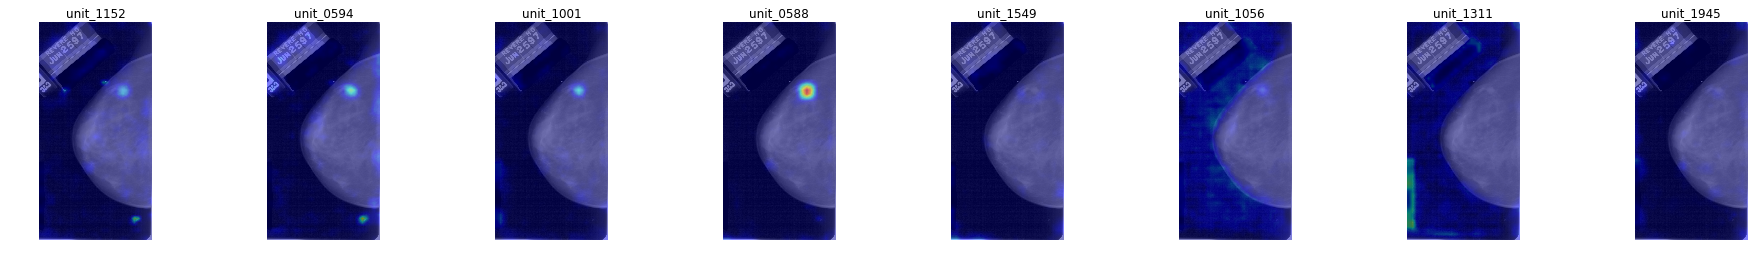

In [143]:
# Pretty Print Reports
# The code bellow prints out the GT lesion annotation, 
# the class activation map, and the unit heat maps for
# the top activating units. The units labeled by experts
# have their unit explanation printed. This is
# how we generated the DeepMiner Reports. 
# Try it for yourself!

for image_index in image_indices: 
    image_name, image = dataset[image_index]
    ## TODO: generate mask on the fly instead of loading precomupted mask
    mask_path = os.path.join(mask_root, image_name.replace('jpg', 'png'))
    mask = None
    if os.path.exists(mask_path):
        mask = Image.open(mask_path).resize((image.size(2), image.size(1)))
        mask = np.asarray(mask)
    for t, m, s in zip(image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]):
        t.mul_(s).add_(m)
    image.clamp_(0, 1)
    image = image.numpy().transpose(1, 2, 0)
    print('image name: {}'.format(image_name))
    print('class {} prob: {}'.format(class_index, max_class_probs[image_index]))
    prob_map = prob_maps[image_index]
    fig, axes = plt.subplots(1, 3, figsize=(3 * 6, 6))
    axes[0].imshow(image)
    axes[0].set_title('Original Mammogram')
    axes[0].axis('off')
    image_size = image.shape[1::-1]
    axes[1].imshow(image)
    axes[1].set_title('Original Mammogram with \n Ground Truth Lession Annotation')
    axes[1].axis('off')
    if mask is not None:
        axes[1].imshow(mask == class_index, alpha=0.5, cmap='jet', vmin=0, vmax=1)
    heatmap = np.asarray(Image.fromarray(prob_map).resize(image_size, resample=Image.BILINEAR))
    axes[2].imshow(image)
    axes[2].imshow(heatmap, alpha=0.5, cmap='jet', vmin=0, vmax=1)
    axes[2].set_title('Mammogram with predicted class {} probability heapmap'.format(class_index))
    axes[2].axis('off')
    plt.show()
    indices = unit_indices[image_index]
    caption = ' '
    for unit_index in indices:
        caption += 'unit_{:04} : '.format(unit_index + 1)
        try:
            caption += unit_labels['unit_'+str(unit_index + 1)]
        except:
            pass
        caption += '\n\t'
    print('class {} top units:\n\t{}'.format(class_index, caption))
    fig, axes = plt.subplots(1, 8, figsize=(8 * 4, 4))
    feature_maps = []
    top_feature_maps = features[image_index][indices]
    top_feature_maps = top_feature_maps - top_feature_maps.min()
    top_feature_maps = top_feature_maps / top_feature_maps.max()
    for j, unit_index in enumerate(indices):
        if j > 7:
            break
        feature_map = top_feature_maps[j]
        image_size = image.shape[1::-1]
        feature_map = np.asarray(Image.fromarray(feature_map).resize(image_size, resample=Image.BILINEAR))
        feature_maps.append(feature_map)
        axes[j].imshow(image)
        axes[j].imshow(feature_map, alpha=0.5, cmap='jet', vmin=0, vmax=1)
        axes[j].set_title('unit_{:04}'.format(unit_index + 1))
        axes[j].axis('off')
    plt.show()
    print('')

image name: cancer_11-A_1673_1.LEFT_CC.LJPEG.1.jpg
class 2 prob: 0.9716702699661255


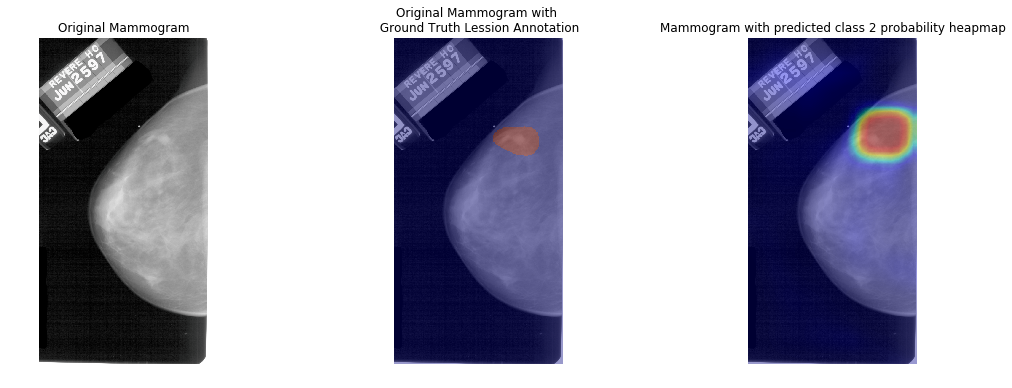

Top activated units with explanations:
1151 Malignant pleomorphic calcifications
1000 Calcified vessels
1548 Normal Breast Tissue
1310 Normal Breast Tissue
1582 Edge of the mass, speculations associated with cancer
1429 Calcifications and arterial calcification
Unit explanations for baseline comparison (not randomized):
unit_1152 Malignant pleomorphic calcifications
unit_1001 Calcified vessels
unit_1549 Normal Breast Tissue
unit_1311 Normal Breast Tissue
unit_1583 Edge of the mass, speculations associated with cancer
unit_2038 Normal Breast Tissue
unit_1122 Pectoralis or inframammary folds
unit_0344 Dense Tissue
unit_1168 Normal Breast Tissue
unit_0842 Normal Breast Tissue
Unit explanations for baseline comparison (YES randomized):
unit_0842 Normal Breast Tissue t/f: 0
unit_1549 Normal Breast Tissue t/f: 1
unit_2038 Normal Breast Tissue t/f: 0
unit_1152 Malignant pleomorphic calcifications t/f: 1
unit_1122 Pectoralis or inframammary folds t/f: 0
unit_1168 Normal Breast Tissue t/f: 0
un

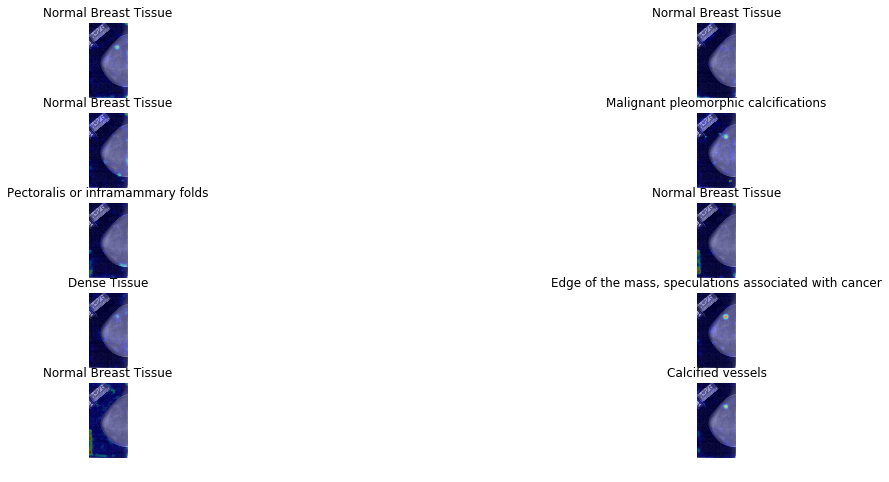

In [176]:
# Print Reports with unit activation maps for comparison
# The code bellow prints out the GT lesion annotation, 
# the class activation map, and the unit heat maps for
# the top activating units, and random units that are 
# not high scoring. The units labeled by experts
# have their unit explanation printed. 

# This dictionary stores which units were top units and which weren't
# Keys are the image name
# Values are an array of 8 binary value, 1/0 if the unit displayed at that position was/wasn't a top unit
top_or_not_labels = {}
for image_index in image_indices: 
    image_name, image = dataset[image_index]
    top_or_not_labels[image_name] = []
    
    # Display original mammogram with lesion annotation if there is one
    mask_path = os.path.join(mask_root, image_name.replace('jpg', 'png'))
    mask = None
    if os.path.exists(mask_path):
        mask = Image.open(mask_path).resize((image.size(2), image.size(1)))
        mask = np.asarray(mask)
    for t, m, s in zip(image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]):
        t.mul_(s).add_(m)
    image.clamp_(0, 1)
    image = image.numpy().transpose(1, 2, 0)
    print('image name: {}'.format(image_name))
    print('class {} prob: {}'.format(class_index, max_class_probs[image_index]))
    prob_map = prob_maps[image_index]
    fig, axes = plt.subplots(1, 3, figsize=(3 * 6, 6))
    axes[0].imshow(image)
    axes[0].set_title('Original Mammogram')
    axes[0].axis('off')
    image_size = image.shape[1::-1]
    axes[1].imshow(image)
    axes[1].set_title('Original Mammogram with \n Ground Truth Lession Annotation')
    axes[1].axis('off')
    if mask is not None:
        axes[1].imshow(mask, alpha=0.4, cmap='jet', vmin=0, vmax=1)
    heatmap = np.asarray(Image.fromarray(prob_map).resize(image_size, resample=Image.BILINEAR))
    axes[2].imshow(image)
    axes[2].imshow(heatmap, alpha=0.4, cmap='jet', vmin=0, vmax=1)
    axes[2].set_title('Mammogram with predicted class {} probability heapmap'.format(class_index))
    axes[2].axis('off')
    plt.show()
    
    
    # Pick top 5 of the top 20 units that have non-empty explanation strings
    # Randomly pick 10 - (# top units) from the list of explained units 
    # that are not already top units for this mammogram
    top_units_w_expl = [] # this are the strings that are the keys for unit_labels (1-based index)
    print("Top activated units with explanations:")
    for unit_index in unit_indices[image_index]:
        try:
            print(f"{unit_index} {unit_labels['unit_'+str(unit_index + 1)]}")
            top_units_w_expl.append('unit_'+str(unit_index + 1))
        except KeyError:
            continue
    
    not_top_units = random.sample(set(unit_labels.keys()) - set(top_units_w_expl), 5)
    test_units_ordered = top_units_w_expl[:5]+not_top_units
    print("Unit explanations for baseline comparison (not randomized):")
    for unit_name in test_units_ordered:
        print(f"{unit_name} {unit_labels[unit_name]}")
    
    # Record which units were/weren't the top units for this mammogram
    ordered_top_or_not_labels = [1,1,1,1,1,0,0,0,0,0]
    random_order = [i for i in range(10)]
    random.shuffle(random_order)
    
    top_or_not_labels[image_name] = [ordered_top_or_not_labels[ind] for ind in random_order]
    test_units_randomized = [test_units_ordered[ind] for ind in random_order]
    
    print("Unit explanations for baseline comparison (YES randomized):")
    test_unit_indices = []
    for ind, unit_name in enumerate(test_units_randomized):
        print(f"{unit_name} {unit_labels[unit_name]} t/f: {top_or_not_labels[image_name][ind]}")
        test_unit_indices.append(int(unit_name.split('_')[1])-1)
    print(test_unit_indices)    
    
    
    # Print units A-H with explanation text
    
    indices = test_unit_indices
    caption = ' '
    for unit_index in indices:
        caption += 'unit_{:04} : '.format(unit_index + 1)
        try:
            caption += unit_labels['unit_{:04}'.format(unit_index + 1)]
        except:
            pass
        caption += '\n\t'
    print('Image {} test explanation units:\n\t{}'.format(image_name, caption))
    fig, axes = plt.subplots(5, 2, figsize=(5 * 4, 2 * 4))
    feature_maps = []
    top_feature_maps = features[image_index][indices]
    top_feature_maps = top_feature_maps - top_feature_maps.min()
    top_feature_maps = top_feature_maps / top_feature_maps.max()
    for j, unit_index in enumerate(indices):
        if j > 9:
            break
        feature_map = top_feature_maps[j]
        image_size = image.shape[1::-1]
        feature_map = np.asarray(Image.fromarray(feature_map).resize(image_size, resample=Image.BILINEAR))
        feature_maps.append(feature_map)
        axes[int(j/2),j%2].imshow(image)
        axes[int(j/2),j%2].imshow(feature_map, alpha=0.4, cmap='jet', vmin=0, vmax=1)
        axes[int(j/2),j%2].set_title( unit_labels['unit_{:04}'.format(unit_index + 1)])
        axes[int(j/2),j%2].axis('off')
    plt.show()
    print('')

In [146]:
unit_labels

{'unit_2038': 'Normal Breast Tissue',
 'unit_1468': 'Masses with smooth edges and Macrocalification',
 'unit_1583': 'Edge of the mass, speculations associated with cancer',
 'unit_0594': 'Calcifications and Masses',
 'unit_0820': 'Mass',
 'unit_0281': 'arterial calcifications',
 'unit_0725': 'suspicious calcifications',
 'unit_0404': 'Normal Breast Tissue',
 'unit_1311': 'Normal Breast Tissue',
 'unit_1299': 'Spiculation',
 'unit_0560': 'Mass with calcifications',
 'unit_1373': 'Masses with calcifications',
 'unit_1168': 'Normal Breast Tissue',
 'unit_1001': 'Calcified vessels',
 'unit_1405': 'Benign calcifications, vascular clarification',
 'unit_1430': 'Calcifications and arterial calcification',
 'unit_1961': 'masses and calcifications of various types (macro or micro)',
 'unit_1962': 'Calcifications',
 'unit_0003': 'Microcalcifications, Dense Tissue',
 'unit_1549': 'Normal Breast Tissue',
 'unit_1780': 'Edge of breast or with the chest wall',
 'unit_1680': 'Calcified vessels',
 'un